In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import sys

sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import numpy as np

from functools import partial
import constants as cst
from loading import Loader
from preprocessing import Preprocessor

In [3]:
data_loader = Loader()
data = data_loader.load_data()

In [4]:
preprocessor = Preprocessor()
preprocessor.preprocess(data)

NotImplementedError: 

# Loading data

In [7]:
data_loader = Loader(sample=1_000_000)
data = data_loader.load_data('../data/inputs/transactions_dataset.csv')

In [10]:
data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


# Data Quality checks

## Quantity

In [24]:
(data['quantity'] <= 0).sum()

0

<AxesSubplot:ylabel='Frequency'>

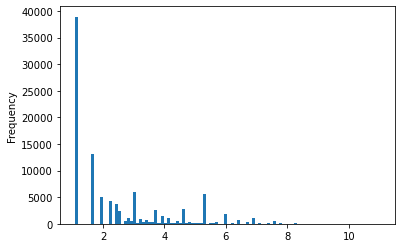

In [30]:
np.log(data['quantity']).plot(kind='hist', bins=100)

## Sales Net

In [31]:
(data['sales_net'] <= 0).sum()

4654

<AxesSubplot:ylabel='Frequency'>

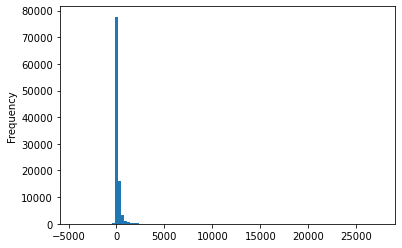

In [33]:
data['sales_net'].plot(kind='hist', bins=100)

## Dates

In [10]:
invoices_date = pd.to_datetime(data['date_invoice'])
print(max(invoices_date))
print(min(invoices_date))

2021-07-13 00:00:00
2016-10-12 00:00:00


In [11]:
orders_date = pd.to_datetime(data['date_order'])
print(max(orders_date))
print(min(orders_date))

2019-09-22 00:00:00
2017-09-22 00:00:00


## Order Channel

In [40]:
data['order_channel'].unique()

array(['online', 'at the store', 'by phone',
       'during the visit of a sales rep', 'other'], dtype=object)

# Sales Cycle Analysis

In [5]:
def avg_date_diff(x):
    # Integer number of Days
    return pd.Timedelta(np.diff(x).mean()).total_seconds()/(60*60*24)


In [6]:
data['date_order'] = pd.to_datetime(data['date_order'])

In [7]:
data = data.sort_values('date_order')
test = data.groupby(by=['client_id'])['date_order'].agg(['size', 'min', 'max', avg_date_diff]).reset_index()

/var/folders/4b/dwg2nq6d56bdx_qd1pqxp_800000gn/T/ipykernel_26839/2249865063.py:3: RuntimeWarning: Mean of empty slice.
  return pd.Timedelta(np.diff(x).mean()).total_seconds()/(60*60*24)
/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
test.loc[(test['avg_date_diff'] >= 0) & (test['avg_date_diff'] < 10), 'frequency_category'] = 'freq'
test.loc[(test['avg_date_diff'] >= 10) & (test['avg_date_diff'] < 35), 'frequency_category'] = 'med'
test.loc[(test['avg_date_diff'] >= 35) | (test['avg_date_diff'] == 0), 'frequency_category'] = 'infreq'

In [9]:
test.to_csv('intermediate_step.csv')

In [3]:
test = pd.read_csv('intermediate_step.csv', index_col=0)

In [5]:
test.loc[test['frequency_category']!='infreq', :]

,client_id,size,min,avg_date_diff,frequency_category
0,6,40,2017-10-27,16.794872,med
1,7,15,2018-07-16,11.500000,med
2,14,12762,2017-09-25,0.056814,freq
3,18,2224,2017-09-26,0.322087,freq
4,25,4,2018-10-10,0.000000,freq
...,...,...,...,...,...
170582,2274437,2,2018-04-24,0.000000,freq
170583,2274440,111,2017-09-28,6.490909,freq
170584,2274456,22,2019-08-26,0.333333,freq
170587,2274508,8,2017-10-18,0.000000,freq


<AxesSubplot:xlabel='avg_date_diff', ylabel='Count'>

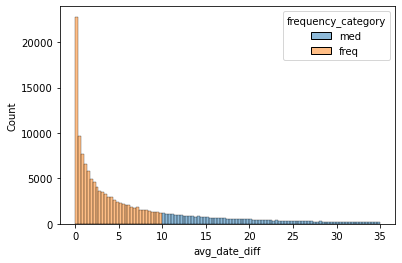

In [12]:
import seaborn as sns

sns.histplot(test.loc[test['frequency_category']!='infreq', :], x='avg_date_diff', hue='frequency_category')

In [22]:
from datetime import datetime, timedelta
datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(20)

datetime.datetime(2019, 9, 2, 0, 0)

In [38]:
from datetime import datetime
test['is_churn'] = 0
test.loc[(test['frequency_category'] == 'freq') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(40)), 'is_churn'] = 1
test.loc[(test['frequency_category'] == 'med') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(100)), 'is_churn'] = 1
test.loc[(test['frequency_category'] == 'infreq') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(400)), 'is_churn'] = 1

In [39]:
print((test['is_churn'] == 1).sum())
print((test['is_churn'] == 1).sum()/170589)

58316
0.34185088135811803


# Feature engineering

In [31]:
data = pd.read_csv('../data/train/train_transactions.csv', index_col=0)

In [33]:
data['date_order'] = pd.to_datetime(data['date_order'])
data = data.sort_values('date_order')

In [34]:
def purchase_frequency(dates):
    return pd.Timedelta(np.diff(dates.unique()).mean()).total_seconds()/(60*60*24)

def time_delay(dates, n=1):
    try:
        return pd.Timedelta(dates.iloc[-n] - dates.iloc[-n-1]).total_seconds()/(60*60*24)
    except IndexError:
        return np.nan
    
def lifetime(dates):
    return pd.Timedelta(dates.iloc[-1] - dates.iloc[0]).total_seconds()/(60*60*24)

def time_from_today(dates, n=0):
    return pd.Timedelta(cst.MAX_DATE - dates.iloc[n]).total_seconds()/(60*60*24)

def last(sequence, n=1):
    try:
        return sequence.iloc[-n]
    except IndexError:
        return np.nan

def item_freq(series, item):
    if not np.isin(item, series):
        return 0
    else:
        return series.value_counts(normalize=True)[item]
        


In [47]:
features = data.groupby(by="client_id", as_index=False).agg(
    # online_percent=("order_channel", partial(item_freq, item="online")),
    # phone_percent=("order_channel", partial(item_freq, item="by phone")),
    # store_percent=("order_channel", partial(item_freq, item="at the store")),
    # visit_percent=(
    #     "order_channel",
    #     partial(item_freq, item="during the visit of a sales rep"),
    # ),
    # other_percent=("order_channel", partial(item_freq, item="other")),
    mean_qty=("quantity", "mean"),
    max_qty=("quantity", "max"),
    min_qty=("quantity", "min"),
    std_qty=("quantity", "std"),
    last_qty_1=("quantity", partial(last, n=1)),
    last_qty_2=("quantity", partial(last, n=2)),
    last_qty_3=("quantity", partial(last, n=3)),
    last_qty_4=("quantity", partial(last, n=4)),
    mean_sales=("sales_net", "mean"),
    max_sales=("sales_net", "max"),
    min_sales=("sales_net", "min"),
    std_sales=("sales_net", "std"),
    last_sales_1=("sales_net", partial(last, n=1)),
    last_sales_2=("sales_net", partial(last, n=2)),
    last_sales_3=("sales_net", partial(last, n=3)),
    last_sales_4=("sales_net", partial(last, n=4)),
    n_branch=("branch_id", "nunique"),
    n_product=("product_id", "nunique"),
    purchase_freq=("date_order", purchase_frequency),
    n_purchases=("date_order", 'count'),
    delay_purchase_n1=("date_order", partial(time_delay, n=1)),
    delay_purchase_n2=("date_order", partial(time_delay, n=2)),
    delay_purchase_n3=("date_order", partial(time_delay, n=3)),
    delay_purchase_n4=("date_order", partial(time_delay, n=4)),
    client_age=("date_order", partial(time_from_today, n=0)),
    time_from_last_purchase=("date_order", partial(time_from_today, n=-1)),
    client_lifetime=("date_order", lifetime),
)
features

/var/folders/4b/dwg2nq6d56bdx_qd1pqxp_800000gn/T/ipykernel_38604/1958035026.py:2: RuntimeWarning: Mean of empty slice.
  return pd.Timedelta(np.diff(dates.unique()).mean()).total_seconds()/(60*60*24)
/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,client_id,mean_qty,max_qty,min_qty,std_qty,last_qty_1,last_qty_2,last_qty_3,last_qty_4,mean_sales,...,n_product,purchase_freq,n_purchases,delay_purchase_n1,delay_purchase_n2,delay_purchase_n3,delay_purchase_n4,client_age,time_from_last_purchase,client_lifetime
0,6,43.166667,401,3,84.589889,3,3.0,3.0,121.0,145.516130,...,24,52.666667,24,0.0,1.0,33.0,48.0,695.0,221.0,474.0
1,7,6.600000,17,3,4.792852,5,3.0,5.0,3.0,79.385139,...,10,161.000000,15,0.0,0.0,0.0,0.0,433.0,272.0,161.0
2,14,115.213091,7201,3,439.127686,61,61.0,41.0,21.0,264.616990,...,4106,1.437642,10343,0.0,0.0,0.0,0.0,727.0,93.0,634.0
3,18,35.180212,2301,3,104.318822,3,3.0,9.0,5.0,117.081811,...,684,2.548387,1698,0.0,0.0,0.0,0.0,726.0,94.0,632.0
4,25,27.000000,51,3,27.712813,51,3.0,3.0,51.0,93.646524,...,4,NaN,4,0.0,0.0,0.0,NaN,347.0,347.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163901,2274440,31.979592,201,3,54.991092,101,3.0,3.0,3.0,197.010838,...,83,30.047619,98,0.0,24.0,0.0,0.0,724.0,93.0,631.0
163902,2274479,4.250000,7,3,1.832251,7,7.0,3.0,5.0,61.990175,...,5,485.000000,8,0.0,0.0,0.0,485.0,692.0,207.0,485.0
163903,2274504,3.500000,5,3,1.000000,5,3.0,3.0,3.0,28.314150,...,4,425.000000,4,425.0,0.0,0.0,NaN,689.0,264.0,425.0
163904,2274508,28.500000,101,3,48.342528,3,5.0,5.0,101.0,18.175474,...,4,NaN,4,0.0,0.0,0.0,NaN,704.0,704.0,0.0


In [49]:
import os
features.to_csv(os.path.join('..',cst.FEATURES_PATH))

# Extract labels

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
230799,2017-09-22,2017-09-25,529686,791423,17.636400,3,online,4097
120793,2017-09-22,2017-09-25,2821712,688261,1062.931200,3,online,4157
233197,2017-09-22,2017-09-25,183015,585799,199.189200,3,online,5274
259160,2017-09-22,2017-09-25,2634108,585799,445.740000,3,online,5274
223459,2017-09-22,2017-09-25,686712,688261,216.218400,3,online,4157
...,...,...,...,...,...,...,...,...
54552654,2019-06-23,2019-06-24,2104306,1060424,763.002000,3,by phone,5663
54390904,2019-06-23,2019-06-24,2657410,1060424,203.975868,401,by phone,5663
60244798,2019-06-23,2019-08-22,276087,66625,66.240000,3,by phone,3194
62167325,2019-06-23,2019-09-11,539670,17765,0.056120,61,by phone,10742


In [55]:
freqs = data.groupby(by="client_id", as_index=False).agg(
    last_purchase=('date_order', 'max'), 
    frequency=('date_order', purchase_frequency), 
)

/var/folders/4b/dwg2nq6d56bdx_qd1pqxp_800000gn/T/ipykernel_38604/1958035026.py:2: RuntimeWarning: Mean of empty slice.
  return pd.Timedelta(np.diff(dates.unique()).mean()).total_seconds()/(60*60*24)
/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [58]:
from datetime import timedelta
split_day = cst.MAX_DATE - timedelta(90)

In [64]:
freq_churn = split_day - timedelta(30)
medium_churn = split_day - timedelta(90)

In [69]:
freqs.loc[(freqs['frequency'] > 0) & (freqs['frequency'] < 10), 'client_category'] = 'freq_buyer'
freqs.loc[(freqs['frequency'] >= 10) & (freqs['frequency'] < 32), 'client_category'] = 'med_buyer'
freqs.loc[(freqs['frequency'] >=32) | (freqs['frequency'] == 0), 'client_category'] = 'infreq_buyer'

In [70]:
freqs.loc[(freqs['client_category']=='freq_buyer') & (freqs['last_purchase'] <= freq_churn), 'is_churn'] = 1
freqs.loc[(freqs['client_category']=='freq_buyer') & (freqs['last_purchase'] > freq_churn), 'is_churn'] = 0
freqs.loc[(freqs['client_category']=='med_buyer') & (freqs['last_purchase'] <= medium_churn), 'is_churn'] = 1
freqs.loc[(freqs['client_category']=='med_buyer') & (freqs['last_purchase'] > medium_churn), 'is_churn'] = 0

In [77]:
freqs.to_csv(os.path.join('..', cst.TRAIN_TARGET_PATH))